In [135]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time
import matplotlib.pyplot as plt 

sys.path.append("../")
from proj_mod import training, data_processing
importlib.reload(training);
importlib.reload(data_processing);

In [136]:
device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


# Data preparation

## Data loading

In [137]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")

In [138]:
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")
df_RV_ts.pivot(index="row_id",columns=["sub_int_num"],values=["sub_int_RV"])

sub_int_RV                                                        \
sub_int_num         1         2         3         4         5             6    
row_id                                                                         
0-1000        0.000341  0.000000  0.000023  0.000000  0.000170  3.818799e-07   
0-10000       0.000290  0.000191  0.000087  0.000193  0.000241  3.154886e-04   
0-10005       0.000000  0.000000  0.001554  0.002177  0.002303  4.375100e-04   
0-10017       0.000142  0.000142  0.001464  0.001086  0.000068  6.771948e-05   
0-10030       0.000327  0.000058  0.000293  0.000842  0.000120  2.586782e-04   
...                ...       ...       ...       ...       ...           ...   
99-9972       0.000197  0.000181  0.000171  0.000172  0.000369  2.503467e-04   
99-9973       0.000821  0.000346  0.000691  0.001591  0.000863  9.650211e-04   
99-9976       0.000569  0.001101  0.001002  0.000430  0.000797  7.203531e-04   
99-9988       0.000040  0.000069  0.000123  0.000056  0.000016  1.957402e-04   
99-9993       0.000249  0.000179  0.000155  0.000025  0.000325  1.798617e-04   

                                                     ...                      \
sub_int_num        7         8         9         10  ...        51        52   
row_id                                               ...                       
0-1000       0.000089  0.000552  0.000012  0.000000  ...  0.000265  0.000000   
0-10000      0.000000  0.000247  0.000265  0.000000  ...  0.000202  0.000375   
0-10005      0.000617  0.001199  0.002306  0.001215  ...  0.000000  0.000486   
0-10017      0.000899  0.000064  0.000593  0.000451  ...  0.000029  0.000000   
0-10030      0.000221  0.000436  0.000099  0.000008  ...  0.000410  0.000437   
...               ...       ...       ...       ...  ...       ...       ...   
99-9972      0.000349  0.000356  0.000390  0.000050  ...  0.000075  0.000185   
99-9973      0.000504  0.001925  0.000641  0.000382  ...  0.001081  0.001095   
99-9976      0.000586  0.000538  0.000570  0.000781  ...  0.000508  0.000406   
99-9988      0.000071  0.000095  0.000063  0.000030  ...  0.000034  0.000176   
99-9993      0.000080  0.000125  0.000126  0.000205  ...  0.000099  0.000370   

                                                                   \
sub_int_num        53        54        55        56            57   
row_id                                                              
0-1000       0.000214  0.000003  0.000000  0.000118  2.313288e-04   
0-10000      0.000616  0.000564  0.000000  0.000023  3.777703e-08   
0-10005      0.000050  0.001761  0.001617  0.001801  2.552987e-03   
0-10017      0.001293  0.002092  0.000994  0.000848  3.104404e-03   
0-10030      0.000004  0.000215  0.000457  0.000183  4.842470e-04   
...               ...       ...       ...       ...           ...   
99-9972      0.000314  0.000318  0.000115  0.000143  9.916624e-05   
99-9973      0.000425  0.000789  0.001295  0.000596  1.862600e-03   
99-9976      0.000662  0.000338  0.000710  0.000179  5.946683e-04   
99-9988      0.000140  0.000129  0.000175  0.000019  1.440137e-04   
99-9993      0.000929  0.000328  0.000251  0.000204  2.728767e-04   

                                               
sub_int_num            58        59        60  
row_id                                         
0-1000       1.060893e-05  0.000111  0.000288  
0-10000      3.777703e-08  0.000020  0.000310  
0-10005      5.364106e-04  0.000872  0.000000  
0-10017      1.224910e-03  0.001316  0.003287  
0-10030      0.000000e+00  0.000756  0.000005  
...                   ...       ...       ...  
99-9972      1.809852e-04  0.000334  0.000089  
99-9973      7.668418e-04  0.001035  0.002115  
99-9976      1.509652e-04  0.000388  0.000403  
99-9988      3.200939e-05  0.000041  0.000007  
99-9993      2.108380e-04  0.000126  0.000353  

[428932 rows x 60 columns]

In [139]:
RV_tab=pd.read_csv("../processed_data/RV_by_row_id.csv")
RV_tab

,time_id,RV,row_id,stock_id
0,5,0.002185,93-5,93
1,11,0.001205,93-11,93
2,16,0.001461,93-16,93
3,31,0.001693,93-31,93
4,62,0.001296,93-62,93
...,...,...,...,...
428927,32751,0.002337,104-32751,104
428928,32753,0.001500,104-32753,104
428929,32758,0.002272,104-32758,104
428930,32763,0.001949,104-32763,104


In [140]:
# Creates tabular data, most specifically 'emb_id'
unique_ids = sorted(RV_tab['stock_id'].unique())
id_to_emb = {stock_id: i for i, stock_id in enumerate(unique_ids)}
RV_tab['emb_id'] = RV_tab['stock_id'].map(id_to_emb)
RV_tab

,time_id,RV,row_id,stock_id,emb_id
0,5,0.002185,93-5,93,81
1,11,0.001205,93-11,93,81
2,16,0.001461,93-16,93,81
3,31,0.001693,93-31,93,81
4,62,0.001296,93-62,93,81
...,...,...,...,...,...
428927,32751,0.002337,104-32751,104,92
428928,32753,0.001500,104-32753,104,92
428929,32758,0.002272,104-32758,104,92
428930,32763,0.001949,104-32763,104,92


In [141]:
df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)
df_target

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


## Dataset creation

In [142]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



In [143]:
train_dataset[20000]

(tensor([4.6594e-04, 1.5794e-04, 2.6052e-04, 2.0006e-04, 4.6036e-04, 4.1584e-04,
         9.8932e-04, 4.7264e-04, 2.1441e-04, 2.9363e-05, 2.4447e-04, 2.9892e-04,
         7.5965e-04, 6.9540e-04, 6.2064e-05, 9.8745e-04, 1.1972e-03, 5.2220e-04,
         1.2480e-04, 3.2021e-04, 2.0767e-04, 2.9159e-04, 1.3637e-04, 5.0568e-04,
         7.6126e-04, 5.4608e-05, 5.1065e-04, 5.1155e-04, 1.2982e-04, 1.5398e-04,
         6.1349e-04, 8.6339e-04, 4.7770e-04, 6.8327e-04, 5.8174e-04, 1.9467e-05,
         2.8003e-04, 3.1872e-04, 6.9253e-04, 8.4858e-05, 5.5608e-04, 1.2923e-03,
         7.3301e-04, 3.3100e-04, 3.8636e-04, 1.3472e-04, 4.8604e-04, 2.2667e-04,
         5.7036e-04, 2.3896e-04, 6.0563e-04, 2.2564e-04, 4.4306e-04, 1.6629e-04,
         2.7551e-04, 3.5369e-04, 3.3014e-04, 4.8192e-04, 5.2923e-04, 3.0226e-04,
         9.0000e+01]),
 tensor([0.0053]))

In [144]:
train_dataset.get_row_id(20000)

'102-4084'

In [145]:
# The assigned 'emb_id' looks good
id_to_emb.get(102)

90

In [146]:
# Target looks good too
df_target[df_target["row_id"]=="102-4084"]

,stock_id,time_id,target,row_id
345167,102,4084,0.005318,102-4084


## A little bit of Pytorch

In [147]:
# The tensor is unrelated to anything. This part is just to illustrate how Pytorch works
row_indices = torch.arange(1,11).unsqueeze(1)
column_indices = torch.arange(1,9).unsqueeze(0)
ref_tensor = row_indices*column_indices
ref_tensor

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 2,  4,  6,  8, 10, 12, 14, 16],
        [ 3,  6,  9, 12, 15, 18, 21, 24],
        [ 4,  8, 12, 16, 20, 24, 28, 32],
        [ 5, 10, 15, 20, 25, 30, 35, 40],
        [ 6, 12, 18, 24, 30, 36, 42, 48],
        [ 7, 14, 21, 28, 35, 42, 49, 56],
        [ 8, 16, 24, 32, 40, 48, 56, 64],
        [ 9, 18, 27, 36, 45, 54, 63, 72],
        [10, 20, 30, 40, 50, 60, 70, 80]])

In [148]:
ref_tensor.unsqueeze(1).expand(-1,20,-1)

tensor([[[ 1,  2,  3,  ...,  6,  7,  8],
         [ 1,  2,  3,  ...,  6,  7,  8],
         [ 1,  2,  3,  ...,  6,  7,  8],
         ...,
         [ 1,  2,  3,  ...,  6,  7,  8],
         [ 1,  2,  3,  ...,  6,  7,  8],
         [ 1,  2,  3,  ...,  6,  7,  8]],

        [[ 2,  4,  6,  ..., 12, 14, 16],
         [ 2,  4,  6,  ..., 12, 14, 16],
         [ 2,  4,  6,  ..., 12, 14, 16],
         ...,
         [ 2,  4,  6,  ..., 12, 14, 16],
         [ 2,  4,  6,  ..., 12, 14, 16],
         [ 2,  4,  6,  ..., 12, 14, 16]],

        [[ 3,  6,  9,  ..., 18, 21, 24],
         [ 3,  6,  9,  ..., 18, 21, 24],
         [ 3,  6,  9,  ..., 18, 21, 24],
         ...,
         [ 3,  6,  9,  ..., 18, 21, 24],
         [ 3,  6,  9,  ..., 18, 21, 24],
         [ 3,  6,  9,  ..., 18, 21, 24]],

        ...,

        [[ 8, 16, 24,  ..., 48, 56, 64],
         [ 8, 16, 24,  ..., 48, 56, 64],
         [ 8, 16, 24,  ..., 48, 56, 64],
         ...,
         [ 8, 16, 24,  ..., 48, 56, 64],
         [ 8, 16, 24, 

# Model and plotting function

In [149]:
# TODO: The splitting of x, as of now, only works for this particular dataset, doing the splitting using the capabilites of RV_Dataset remains to be done.
# Maybe the dataset should have an internal variable that tells us how many differet stocks there are in order to pass that to this model directly....?
# Is there a way to reuse RV_RNN_conv in RV_RNN_conv to avoid code duplication?


class RV_RNN_conv_emb(nn.Module):        
    #Created 07/17/25 from previous RV_RNN_conv
    #NEW n_stocks, stock_emb_dim
    def __init__(self,n_diff,rnn_num_layer,rnn_drop_out,rnn_type="rnn",rnn_act="tanh",proj_dim=32,rnn_hidden_size=32,input_scaler=10000, n_stocks=112, stock_emb_dim=8):
        """
        :param n_diff: Decides how many derivative features is wanted in the time series. 
        :param rnn_num_layer: num_layer parameter for rnn. 
        :param rnn_drop_out: dropout parameter for rnn. 
        :param rnn_act: Defaulted to "tanh". Nonlinearity parameter for rnn. 
        :param proj_dim: Defaulted to 32. Decided the dimension of projection before feeding into rnn. 
        :param rnn_hidden_size: Defaulted to 32. The hidden_size parameter for rnn. 
        :param input_scaler: Defaulted to 10000. Set a scaling to input, a lot of timeseries values of our data are extremely close to zero. 
        :param rnn_type: 'rnn', 'lstm', or 'gru'
        """
        super().__init__()
        
        self.input_scaler=input_scaler
        self.frozen_conv=training.frozen_diff_conv(n_diff=n_diff)
        self.linear_proj_input=nn.Linear(n_diff+1,proj_dim)

        self.rnn_type = rnn_type

        # NEW
        self.stock_embedding = nn.Embedding(num_embeddings=n_stocks, embedding_dim=stock_emb_dim) # NEW
        rnn_input_size = proj_dim + stock_emb_dim #NEW
        
        if rnn_type == "rnn":
            # CHANGED rnn_input_size
            self.RNN_layer=nn.RNN(input_size=rnn_input_size,
                                  hidden_size=rnn_hidden_size,
                                  num_layers=rnn_num_layer,
                                  nonlinearity=rnn_act,
                                  batch_first=True,
                                  dropout=rnn_drop_out)
        elif rnn_type == "lstm":
            if rnn_act is not None:
                print(f"Warning: rnn_act='{rnn_act}' is ignored when using rnn_type='lstm'")
            # CHANGED rnn_input_size
            self.RNN_layer = nn.LSTM(input_size=rnn_input_size,
                                     hidden_size=rnn_hidden_size,
                                     num_layers=rnn_num_layer,
                                     batch_first=True,
                                     dropout=rnn_drop_out)
        elif rnn_type == "gru":
            if rnn_act is not None:
                print(f"Warning: rnn_act='{rnn_act}' is ignored when using rnn_type='gru'")
            # CHANGED rnn_input_size
            self.RNN_layer = nn.GRU(input_size=rnn_input_size,
                                    hidden_size=rnn_hidden_size,
                                    num_layers=rnn_num_layer,
                                    batch_first=True,
                                    dropout=rnn_drop_out)
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")
        
        self.linear_post_rnn=nn.Linear(rnn_hidden_size,1)
        self.frozen_list=["frozen_conv"] 
        
    def forward(self,x):
        # NEW
        # Expected shape of x originally: (N, L + 1), where N is the batch number
        x, emb_id = x[:, :-1], x[:, -1].long() # (N,L) and (N,) respectively  # NEW
        
        #First, scale the input, and unsqueese to add in one dimension in dim 1 as channel. This is needed for convolution. 
        x*=self.input_scaler
        x=torch.unsqueeze(x,dim=1) # (N,1,L)
        x=self.frozen_conv(x) # (N, n_diff+1, L)
        x=x.permute(0,2,1) # (N, L, n_diff+1)
        x=self.linear_proj_input(x) # (N, L, proj_dim)

        # NEW
        stock_emb = self.stock_embedding(emb_id) # (N, stock_emb_dim) Do note that nn.Embedding directly maps one integer to a vector of dimension stock_emb_dim (in batches) # NEW
        stock_emb = stock_emb.unsqueeze(1).expand(-1, x.shape[1], -1) # (N, L, stock_emb_dim) # NEW
        x = torch.cat([x, stock_emb], dim=-1) # (N, L, proj_dim + stock_emb_dim) # NEW
        
        
        x=self.RNN_layer(x)[0] # (N, L, hidden_size)
        x=self.linear_post_rnn(x) # (N,L, 1)
        
        return torch.sum(x,dim=1)/self.input_scaler # (N, 1)

def training_plot(train_loss, val_loss, title):
    #Created 07/18/25
    train_loss=[x.cpu() for x in train_loss]
    val_loss=[x.cpu() for x in val_loss]
    
    x=np.arange(len(train_loss))
    
    plt.figure(figsize=(8, 5))
    
    plt.scatter(x,train_loss,c="blue", marker = '+', s=80, linewidths=2.0)
    plt.scatter(x,val_loss,c="orange", marker = '+', s=80, linewidths=2.0)
    
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [150]:
RNN_emb_model=RV_RNN_conv_emb(n_diff=2, rnn_type="lstm",rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=10000, stock_emb_dim=8).to(device=device)

import torch.optim as optim

optimizer=optim.Adam(RNN_emb_model.parameters(),lr=1e-3)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

# Training

## Pure RNN

At  1.117443323135376  epoch  1 has training loss  tensor(0.3258, device='cuda:0')  and validation loss  tensor(0.2398, device='cuda:0') .

At  6.640463590621948  epoch  5 has training loss  tensor(0.2468, device='cuda:0')  and validation loss  tensor(0.2296, device='cuda:0') .

At  13.527668476104736  epoch  10 has training loss  tensor(0.2452, device='cuda:0')  and validation loss  tensor(0.2291, device='cuda:0') .

At  20.555199146270752  epoch  15 has training loss  tensor(0.2445, device='cuda:0')  and validation loss  tensor(0.2270, device='cuda:0') .

At  27.520493745803833  epoch  20 has training loss  tensor(0.2439, device='cuda:0')  and validation loss  tensor(0.2264, device='cuda:0') .

At  34.42608022689819  epoch  25 has training loss  tensor(0.2433, device='cuda:0')  and validation loss  tensor(0.2271, device='cuda:0') .

At  41.54030990600586  epoch  30 has training loss  tensor(0.2433, device='cuda:0')  and validation loss  tensor(0.2283, device='cuda:0') .

At  48.64677

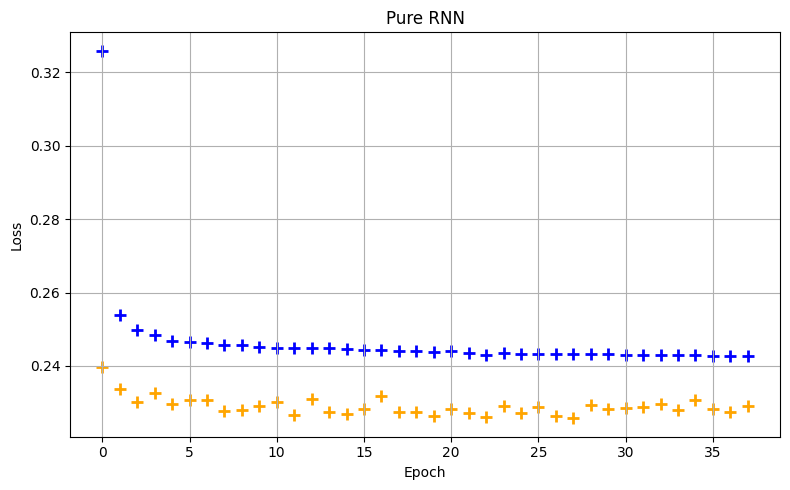

In [153]:
RNN_emb_model=RV_RNN_conv_emb(n_diff=2, 
                              rnn_type="rnn",
                              rnn_act="tanh",
                              rnn_drop_out=0,
                              rnn_hidden_size=32,
                              proj_dim=32,
                              rnn_num_layer=1,
                              input_scaler=10000, 
                              stock_emb_dim=8).to(device=device)

import torch.optim as optim

optimizer=optim.Adam(RNN_emb_model.parameters(),lr=1e-3)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,
                                 model=RNN_emb_model,
                                 train_loader=train_loader,
                                 val_loader=test_loader,
                                 list_train_loss=train_loss,
                                 list_val_loss=val_loss,
                                 device=device,
                                 n_epochs=100,
                                 ot_steps=10,
                                 report_interval=5,
                                 eps=0,scaler=1)

training_plot(train_loss, val_loss, "Pure RNN")

## LSTM

At  1.2501108646392822  epoch  1 has training loss  tensor(0.2594, device='cuda:0')  and validation loss  tensor(0.2309, device='cuda:0') .

At  7.436646461486816  epoch  5 has training loss  tensor(0.2428, device='cuda:0')  and validation loss  tensor(0.2316, device='cuda:0') .

At  15.465277671813965  epoch  10 has training loss  tensor(0.2405, device='cuda:0')  and validation loss  tensor(0.2248, device='cuda:0') .

At  23.341182470321655  epoch  15 has training loss  tensor(0.2394, device='cuda:0')  and validation loss  tensor(0.2263, device='cuda:0') .

At  31.76694083213806  epoch  20 has training loss  tensor(0.2378, device='cuda:0')  and validation loss  tensor(0.2273, device='cuda:0') .

The validation loss has not improved for  10  epochs. Stopping current training loop.

Best model state dictionary of this training loop is reloaded.

According to validation loss, the best model is reached at epoch 14  with validation loss:  tensor(0.2242, device='cuda:0') .
 The total number

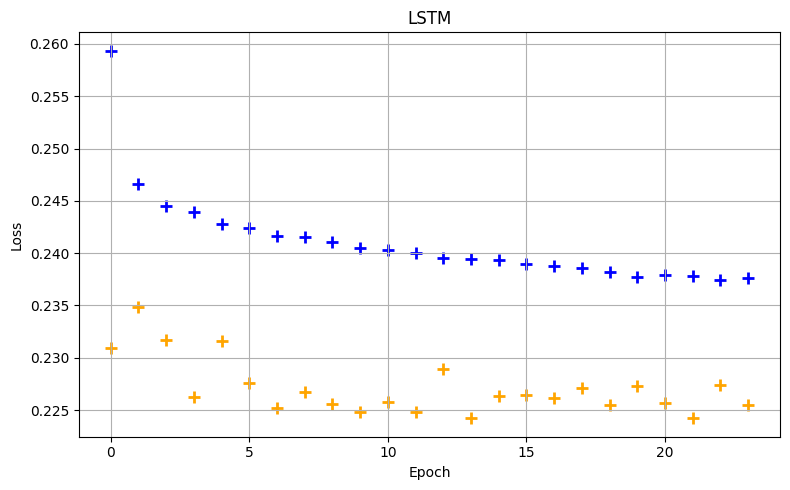

In [158]:
RNN_emb_model=RV_RNN_conv_emb(n_diff=2, 
                              rnn_type="lstm",
                              rnn_act="tanh",
                              rnn_drop_out=0,
                              rnn_hidden_size=32,
                              proj_dim=32,
                              rnn_num_layer=1,
                              input_scaler=10000, 
                              stock_emb_dim=8).to(device=device)

import torch.optim as optim

optimizer=optim.Adam(RNN_emb_model.parameters(),lr=1e-3)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,
                                 model=RNN_emb_model,
                                 train_loader=train_loader,
                                 val_loader=test_loader,
                                 list_train_loss=train_loss,
                                 list_val_loss=val_loss,
                                 device=device,
                                 n_epochs=100,
                                 ot_steps=10,
                                 report_interval=5,
                                 eps=0,scaler=1)

training_plot(train_loss, val_loss, "LSTM")

At  1.2891933917999268  epoch  1 has training loss  tensor(0.2590, device='cuda:0')  and validation loss  tensor(0.2351, device='cuda:0') .

At  7.523680210113525  epoch  5 has training loss  tensor(0.2451, device='cuda:0')  and validation loss  tensor(0.2314, device='cuda:0') .

At  15.22273325920105  epoch  10 has training loss  tensor(0.2422, device='cuda:0')  and validation loss  tensor(0.2295, device='cuda:0') .

At  23.021154165267944  epoch  15 has training loss  tensor(0.2402, device='cuda:0')  and validation loss  tensor(0.2267, device='cuda:0') .

At  30.75545573234558  epoch  20 has training loss  tensor(0.2389, device='cuda:0')  and validation loss  tensor(0.2240, device='cuda:0') .

At  38.44204902648926  epoch  25 has training loss  tensor(0.2380, device='cuda:0')  and validation loss  tensor(0.2268, device='cuda:0') .

At  46.15583395957947  epoch  30 has training loss  tensor(0.2374, device='cuda:0')  and validation loss  tensor(0.2258, device='cuda:0') .

The validatio

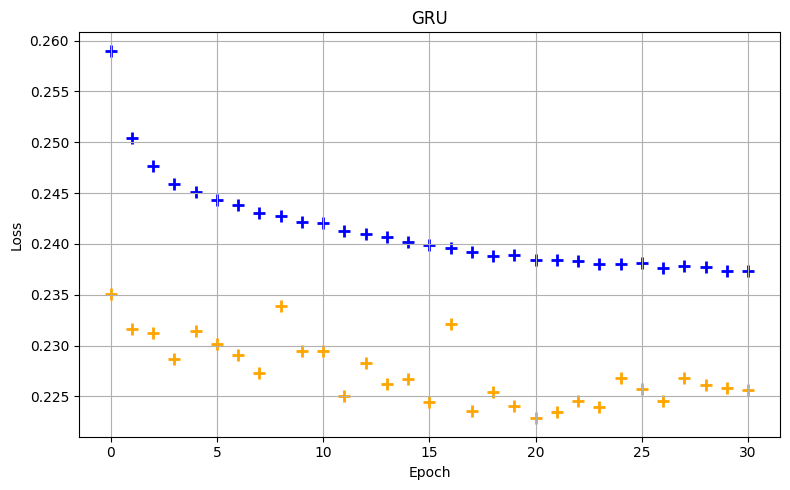

In [156]:
RNN_emb_model=RV_RNN_conv_emb(n_diff=2, 
                              rnn_type="gru",
                              rnn_act="tanh",
                              rnn_drop_out=0,
                              rnn_hidden_size=32,
                              proj_dim=32,
                              rnn_num_layer=1,
                              input_scaler=10000, 
                              stock_emb_dim=8).to(device=device)

import torch.optim as optim

optimizer=optim.Adam(RNN_emb_model.parameters(),lr=1e-3)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,
                                 model=RNN_emb_model,
                                 train_loader=train_loader,
                                 val_loader=test_loader,
                                 list_train_loss=train_loss,
                                 list_val_loss=val_loss,
                                 device=device,
                                 n_epochs=100,
                                 ot_steps=10,
                                 report_interval=5,
                                 eps=0,scaler=1)

training_plot(train_loss, val_loss, "GRU")